# This is a tutorial of using spaMultiVAE for the spatial multi-omics DBiT-seq data

This tutorial was implemented on Macbook Pro M2.

Import modules.

In [1]:
import math, os
from time import time

import torch
from spaMultiVAE import SPAMULTIVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
import h5py
import scanpy as sc
from preprocess import normalize, geneSelection

Setup parameters.

In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'humantonsil_SVG.h5'
        self.select_genes = 0
        self.select_proteins = 0
        self.batch_size = "auto"
        self.maxiter = 5000
        self.train_size = 0.95
        self.patience = 200
        self.lr = 5e-3
        self.weight_decay = 1e-6
        self.gene_noise = 0
        self.protein_noise = 0
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64]
        self.GP_dim = 2
        self.Normal_dim = 18
        self.gene_decoder_layers = [128]
        self.protein_decoder_layers = [128]
        self.init_beta = 10
        self.min_beta = 4
        self.max_beta = 25
        self.KL_loss = 0.025
        self.num_samples = 1
        self.fix_inducing_points = True
        self.inducing_point_steps = 19
        self.fixed_gp_params = False
        self.loc_range = 20.
        self.kernel_scale = 20.
        self.model_file = "model.pt"
        self.final_latent_file = "final_latent.txt"
        self.gene_denoised_counts_file = "gene_denoised_counts.txt"
        self.protein_denoised_counts_file = "protein_denoised_counts.txt"
        self.protein_sigmoid_file = "protein_sigmoid.txt"
        self.gene_enhanced_denoised_counts_file = "gene_enhanced_denoised_counts.txt"
        self.protein_enhanced_denoised_counts_file = "protein_enhanced_denoised_counts.txt"
        self.enhanced_loc_file = "enhanced_loc.txt"
        self.device = "cpu"

args = Args()

Setup inducing points, preprocess count matrices, initial protein background priors, and build the spaMultiVAE model.

In [3]:
data_mat = h5py.File(args.data_file, 'r')
x1 = np.array(data_mat['X_gene']).astype('float64')     # gene count matrix
x2 = np.array(data_mat['X_protein']).astype('float64')  # protein count matrix
loc = np.array(data_mat['pos']).astype('float64')       # location information
data_mat.close()

if args.batch_size == "auto":
    if x1.shape[0] <= 1024:
        args.batch_size = 128
    elif x1.shape[0] <= 2048:
        args.batch_size = 256
    else:
        args.batch_size = 512
else:
    args.batch_size = int(args.batch_size)
    
print(args)

if args.select_genes > 0:
    importantGenes = geneSelection(x1, n=args.select_genes, plot=False)
    x1 = x1[:, importantGenes]
    np.savetxt("selected_genes.txt", importantGenes, delimiter=",", fmt="%i")

if args.select_proteins > 0:
    importantProteins = geneSelection(x2, n=args.select_proteins, plot=False)
    x2 = x2[:, importantProteins]
    np.savetxt("selected_proteins.txt", importantProteins, delimiter=",", fmt="%i")

scaler = MinMaxScaler()
loc = scaler.fit_transform(loc) * args.loc_range

print(x1.shape)
print(x2.shape)
print(loc.shape)

eps = 1e-5
initial_inducing_points = np.mgrid[0:(1+eps):(1./args.inducing_point_steps), 0:(1+eps):(1./args.inducing_point_steps)].reshape(2, -1).T * args.loc_range
print(initial_inducing_points.shape)

adata1 = sc.AnnData(x1, dtype="float64")
adata1 = normalize(adata1,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

adata2 = sc.AnnData(x2, dtype="float64")
adata2 = normalize(adata2,
                  size_factors=False,
                  normalize_input=True,
                  logtrans_input=True)

adata2_no_scale = sc.AnnData(x2, dtype="float64")
adata2_no_scale = normalize(adata2_no_scale,
                  size_factors=False,
                  normalize_input=False,
                  logtrans_input=True)

# Fit GMM model to the protein counts and use the smaller component as the initial values as protein background prior
gm = GaussianMixture(n_components=2, covariance_type="diag", n_init=20).fit(adata2_no_scale.X)
back_idx = np.argmin(gm.means_, axis=0)
protein_log_back_mean = np.log(np.expm1(gm.means_[back_idx, np.arange(adata2_no_scale.n_vars)]))
protein_log_back_scale = np.sqrt(gm.covariances_[back_idx, np.arange(adata2_no_scale.n_vars)])
print("protein_back_mean shape", protein_log_back_mean.shape)

model = SPAMULTIVAE(gene_dim=adata1.n_vars, protein_dim=adata2.n_vars, GP_dim=args.GP_dim, Normal_dim=args.Normal_dim, 
    encoder_layers=args.encoder_layers, gene_decoder_layers=args.gene_decoder_layers, protein_decoder_layers=args.protein_decoder_layers,
    gene_noise=args.gene_noise, protein_noise=args.protein_noise, encoder_dropout=args.dropoutE, decoder_dropout=args.dropoutD,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, N_train=adata1.n_obs, KL_loss=args.KL_loss, init_beta=args.init_beta, min_beta=args.min_beta, 
    max_beta=args.max_beta, protein_back_mean=protein_log_back_mean, protein_back_scale=protein_log_back_scale, dtype=torch.float64, 
    device=args.device)

print(str(model))

(2492, 984)
(2492, 283)
(2492, 2)
(400, 2)
protein_back_mean shape (283,)
SPAMULTIVAE(
  (svgp): SVGP(
    (kernel): CauchyKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=1267, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=64, out_features=20, bias=True)
    (enc_var): Linear(in_features=64, out_features=20, bias=True)
  )
  (gene_decoder): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
  )
  (gene_dec_mean): Sequential(
    (0): Linear(in_features=128, out_features=984, bias=True)
    (

Train the model.

In [4]:
if not os.path.isfile(args.model_file):
    t0 = time()
    model.train_model(pos=loc, gene_ncounts=adata1.X, gene_raw_counts=adata1.raw.X, gene_size_factors=adata1.obs.size_factors, 
                protein_ncounts=adata2.X, protein_raw_counts=adata2.raw.X,
                lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
                train_size=args.train_size, maxiter=args.maxiter, patience=args.patience, save_model=True, model_weights=args.model_file)
    print('Training time: %d seconds.' % int(time() - t0))
else:
    model.load_model(args.model_file)

final_latent = model.batching_latent_samples(X=loc, gene_Y=adata1.X, protein_Y=adata2.X, batch_size=args.batch_size)
np.savetxt(args.final_latent_file, final_latent, delimiter=",")


gene_denoised_counts, protein_denoised_counts, protein_sigmoid = model.batching_denoise_counts(X=loc, gene_Y=adata1.X, protein_Y=adata2.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.gene_denoised_counts_file, gene_denoised_counts, delimiter=",")
np.savetxt(args.protein_denoised_counts_file, protein_denoised_counts, delimiter=",")
np.savetxt(args.protein_sigmoid_file, protein_sigmoid, delimiter=",")

Training
Training epoch 1, ELBO:8845.24704627, Gene NB loss:1794.74566083, Protein NB mixture loss:2953.75140669, Protein background KL:4054.38022947, GP KLD loss:0.05753699, Gaussian KLD loss:4.12662983, noise regularization:0.000000
Current beta 10.329338480578347
Current kernel scale tensor([20.0005])
Training epoch 1, validating ELBO:6888.15421667
Training epoch 2, ELBO:6092.24007332, Gene NB loss:1550.18661292, Protein NB mixture loss:1934.21461802, Protein background KL:2550.06790394, GP KLD loss:0.05065089, Gaussian KLD loss:5.46199621, noise regularization:0.000000
Current beta 10.747842906749597
Current kernel scale tensor([20.0167])
Training epoch 2, validating ELBO:4846.83589513
Training epoch 3, ELBO:4321.12740254, Gene NB loss:1376.08018472, Protein NB mixture loss:1369.11522723, Protein background KL:1531.66894234, GP KLD loss:0.05256849, Gaussian KLD loss:4.00918078, noise regularization:0.000000
Current beta 11.177512703222344
Current kernel scale tensor([20.0336])
Trai

Enhancing spatial resolutions.

In [5]:
# Enhancing spatial resolutions
neigh = NearestNeighbors(n_neighbors=2).fit(loc)
nearest_dist = neigh.kneighbors(loc, n_neighbors=2)[0]
small_distance = np.median(nearest_dist[:,1])/4
loc_new1 = np.empty_like(loc)
loc_new2 = np.empty_like(loc)
loc_new3 = np.empty_like(loc)
loc_new4 = np.empty_like(loc)
loc_new1[:] = loc
loc_new2[:] = loc
loc_new3[:] = loc
loc_new4[:] = loc
loc_new1[:,0] = loc_new1[:,0] - small_distance
loc_new1[:,1] = loc_new1[:,1] + small_distance
loc_new2[:,0] = loc_new2[:,0] + small_distance
loc_new2[:,1] = loc_new2[:,1] + small_distance
loc_new3[:,0] = loc_new3[:,0] - small_distance
loc_new3[:,1] = loc_new3[:,1] - small_distance
loc_new4[:,0] = loc_new4[:,0] + small_distance
loc_new4[:,1] = loc_new4[:,1] - small_distance
loc_enhance = np.concatenate((loc_new1, loc_new2, loc_new3, loc_new4, loc), axis=0)

_, enhanced_gene_denoised_counts, enhanced_protein_denoised_counts = model.batching_predict_samples(X_test=loc_enhance, 
                X_train=loc, gene_Y_train=adata1.X, protein_Y_train=adata2.X, batch_size=args.batch_size, n_samples=25)
np.savetxt(args.gene_enhanced_denoised_counts_file, enhanced_gene_denoised_counts, delimiter=",")
np.savetxt(args.protein_enhanced_denoised_counts_file, enhanced_protein_denoised_counts, delimiter=",")
np.savetxt(args.enhanced_loc_file, loc_enhance, delimiter=",")

K-means clustering of latent embedding.

In [6]:
from sklearn.cluster import KMeans

latent = np.loadtxt("final_latent.txt", delimiter=",")
y_pred = KMeans(n_clusters=7, n_init=100).fit_predict(latent[:, :])

np.savetxt("kmeans_clustering_labels.txt", y_pred, delimiter=",", fmt="%i")

Plot results in R and ggplot2.

In [1]:
rm(list=ls())
library(rhdf5)
library(ggplot2)
library(cowplot)
library(repr)

Plot k-means clustering result.

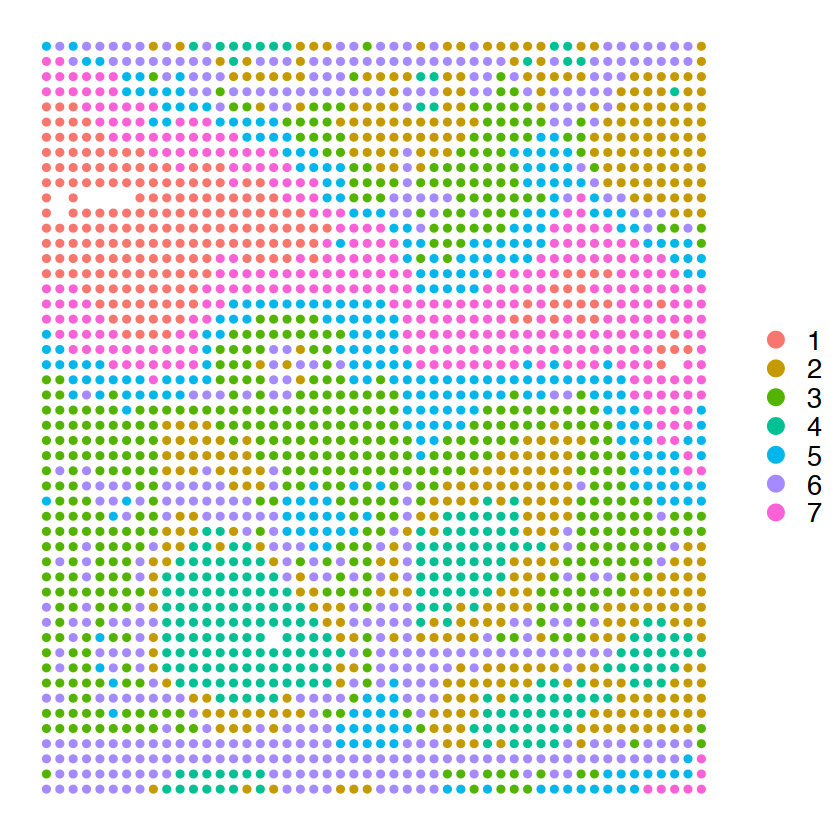

In [2]:
spamultivae.label <- as.numeric(readLines("kmeans_clustering_labels.txt")) + 1
pos <- t(h5read("humantonsil_SVG.h5", "pos"))
label.dat <- data.frame(pos, label=spamultivae.label, 
                        method="spaMultiVAE")
label.dat$label <- factor(label.dat$label, levels=1:10)

ggplot(label.dat, aes(x=X1, y=X2, color=label)) + geom_point(size=1.5) + 
  scale_y_reverse() + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), text = element_text(size=20)) +
  guides(colour = guide_legend(override.aes = list(size=4)))

Plot denoised protein counts.

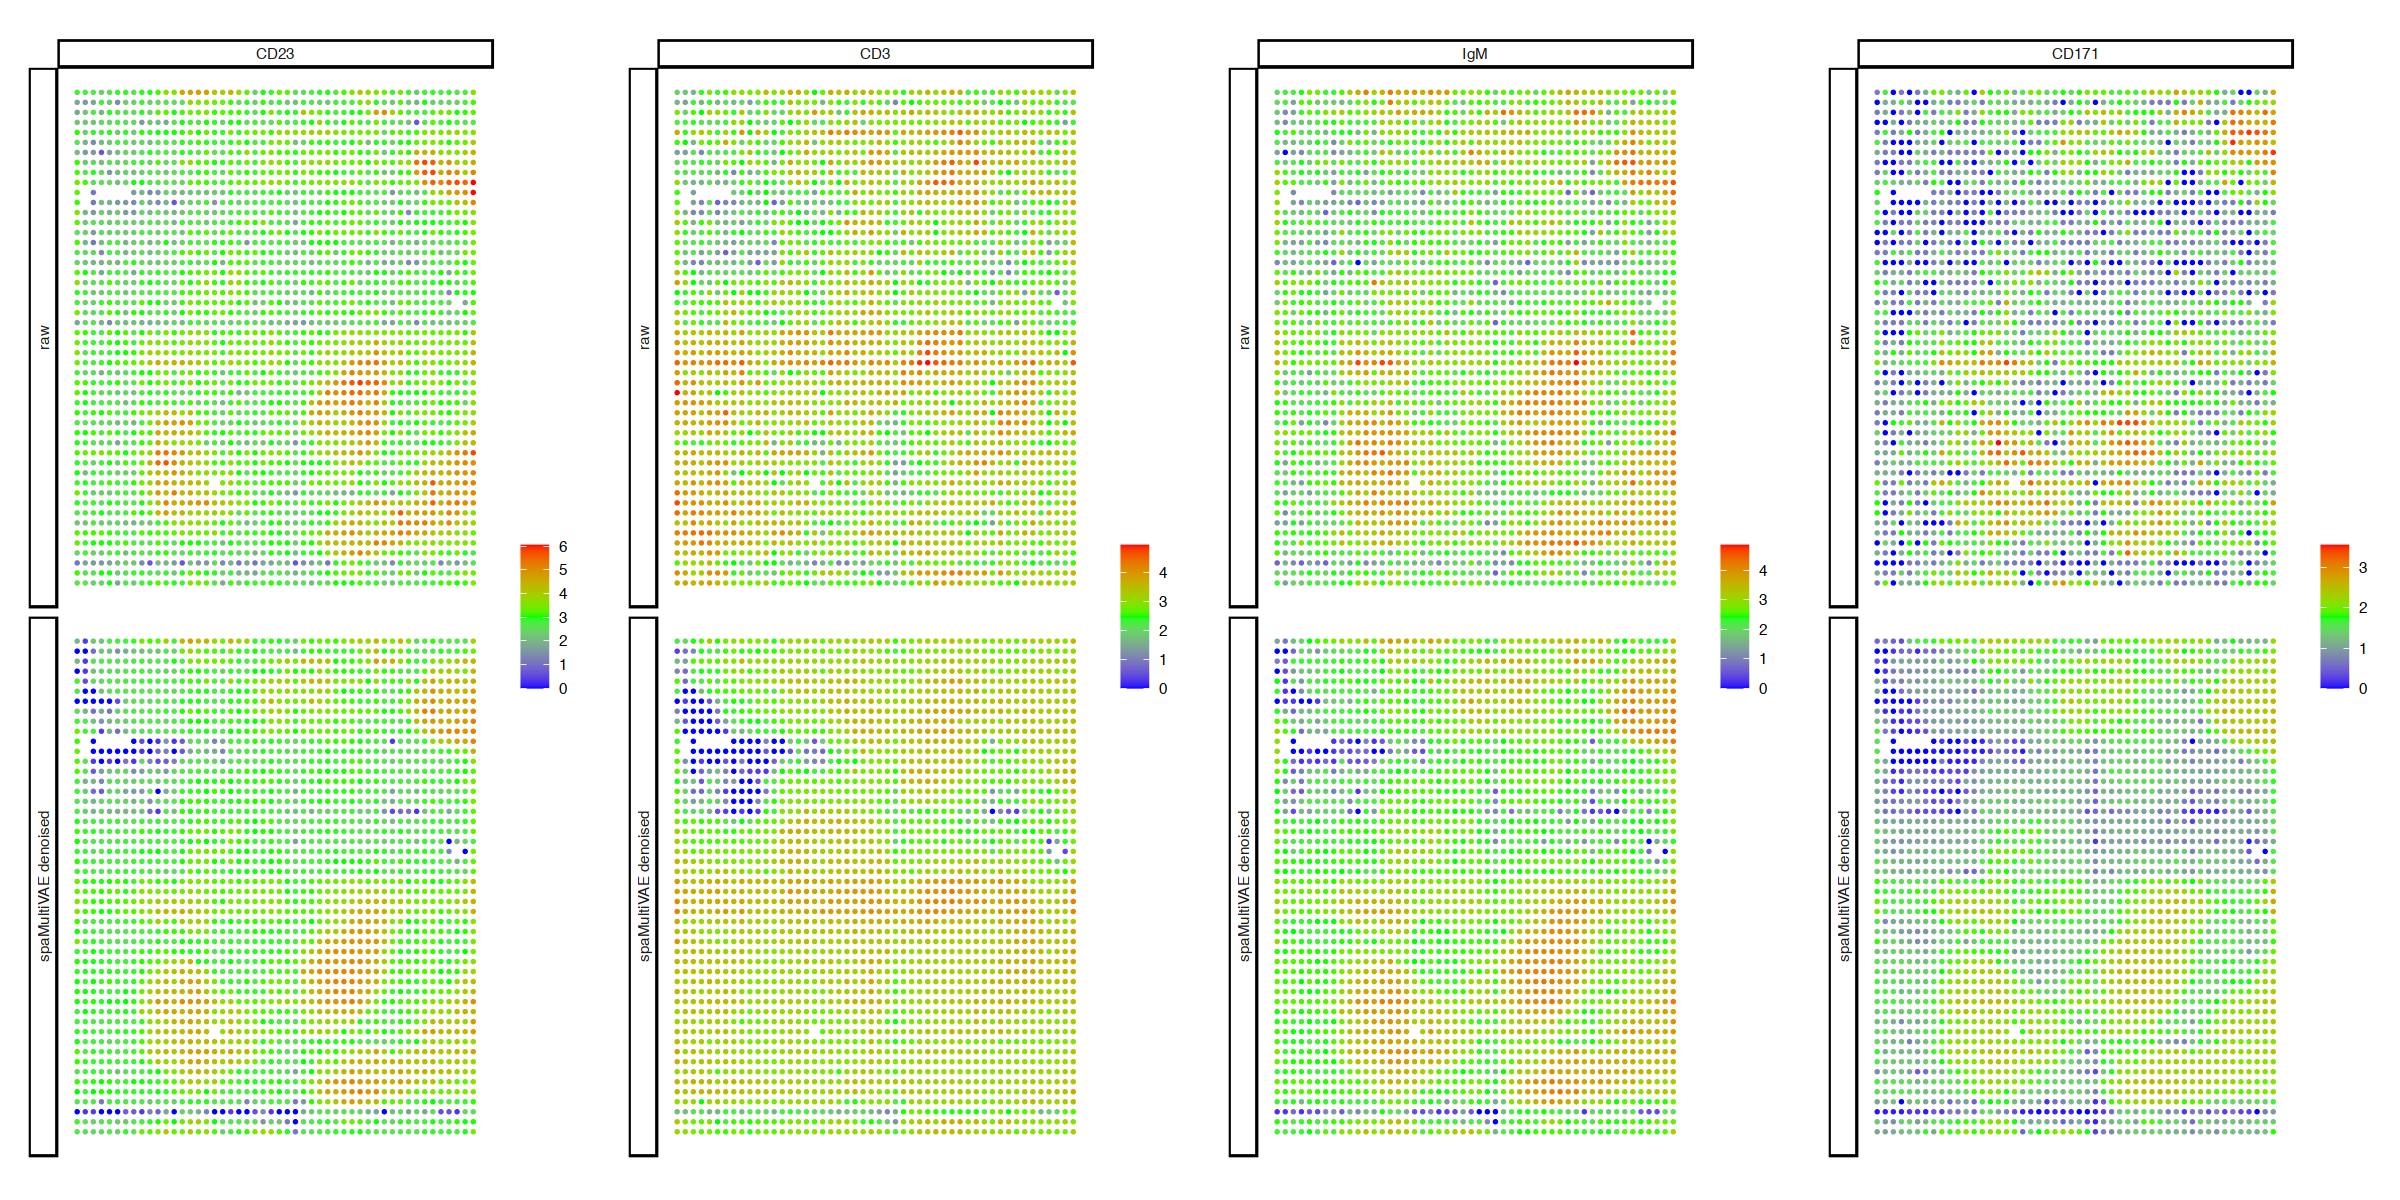

In [3]:
protein.name <- h5read("humantonsil_SVG.h5", "protein")
raw.protein <- t(h5read("humantonsil_SVG.h5", "X_protein"))
colnames(raw.protein) <- protein.name
lograwprotein <- log(raw.protein+1)

protein <- read.table("protein_denoised_counts.txt", sep=",")
colnames(protein) <- protein.name
logprotein <- log(protein+1)

protein.data <- data.frame(exp=c(logprotein[, "CD23.TCTGTATAACCGTCT"], lograwprotein[, "CD23.TCTGTATAACCGTCT"], 
                                 logprotein[, "CD3.CTCATTGTAACTCCT"], lograwprotein[, "CD3.CTCATTGTAACTCCT"], 
                                 logprotein[, "IgM.TAGCGAGCCCGTATA"], lograwprotein[, "IgM.TAGCGAGCCCGTATA"], 
                                 logprotein[, "CD171..LICAM..GATGGACGACAATTC"], lograwprotein[, "CD171..LICAM..GATGGACGACAATTC"]),
                           gene=rep(c("CD23", "CD3", "IgM", "CD171"), each=2*nrow(pos)),
                           data=rep(rep(c("spaMultiVAE denoised", "raw"), each=nrow(pos)), 4),
                           x=rep(pos[,1], 8), y=rep(pos[,2], 8))
protein.data$gene <- factor(protein.data$gene, levels=c("CD23", "CD3", "IgM", "CD171"))


p1 <- ggplot(protein.data[protein.data$gene=="CD23",], aes(x=x, y=y, color=exp)) + geom_point(size=0.5) +
  facet_grid(data~gene, switch="y") + 
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="CD23","exp"]))) +
  scale_y_reverse() + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank())

p2 <- ggplot(protein.data[protein.data$gene=="CD3",], aes(x=x, y=y, color=exp)) + geom_point(size=0.5) +
  facet_grid(data~gene, switch="y") + 
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="CD3","exp"]))) +
  scale_y_reverse() + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank())

p3 <- ggplot(protein.data[protein.data$gene=="IgM",], aes(x=x, y=y, color=exp)) + geom_point(size=0.5) +
  facet_grid(data~gene, switch="y") + 
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="IgM","exp"]))) +
  scale_y_reverse() + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank())

p4 <- ggplot(protein.data[protein.data$gene=="CD171",], aes(x=x, y=y, color=exp)) + geom_point(size=0.5) +
  facet_grid(data~gene, switch="y") + 
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="CD171","exp"]))) +
  scale_y_reverse() + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank())

options(repr.plot.width=20, repr.plot.height=10)
plot_grid(p1, p2, p3, p4, scale=0.95, nrow=1)

Plot resolution enhanced protein counts.

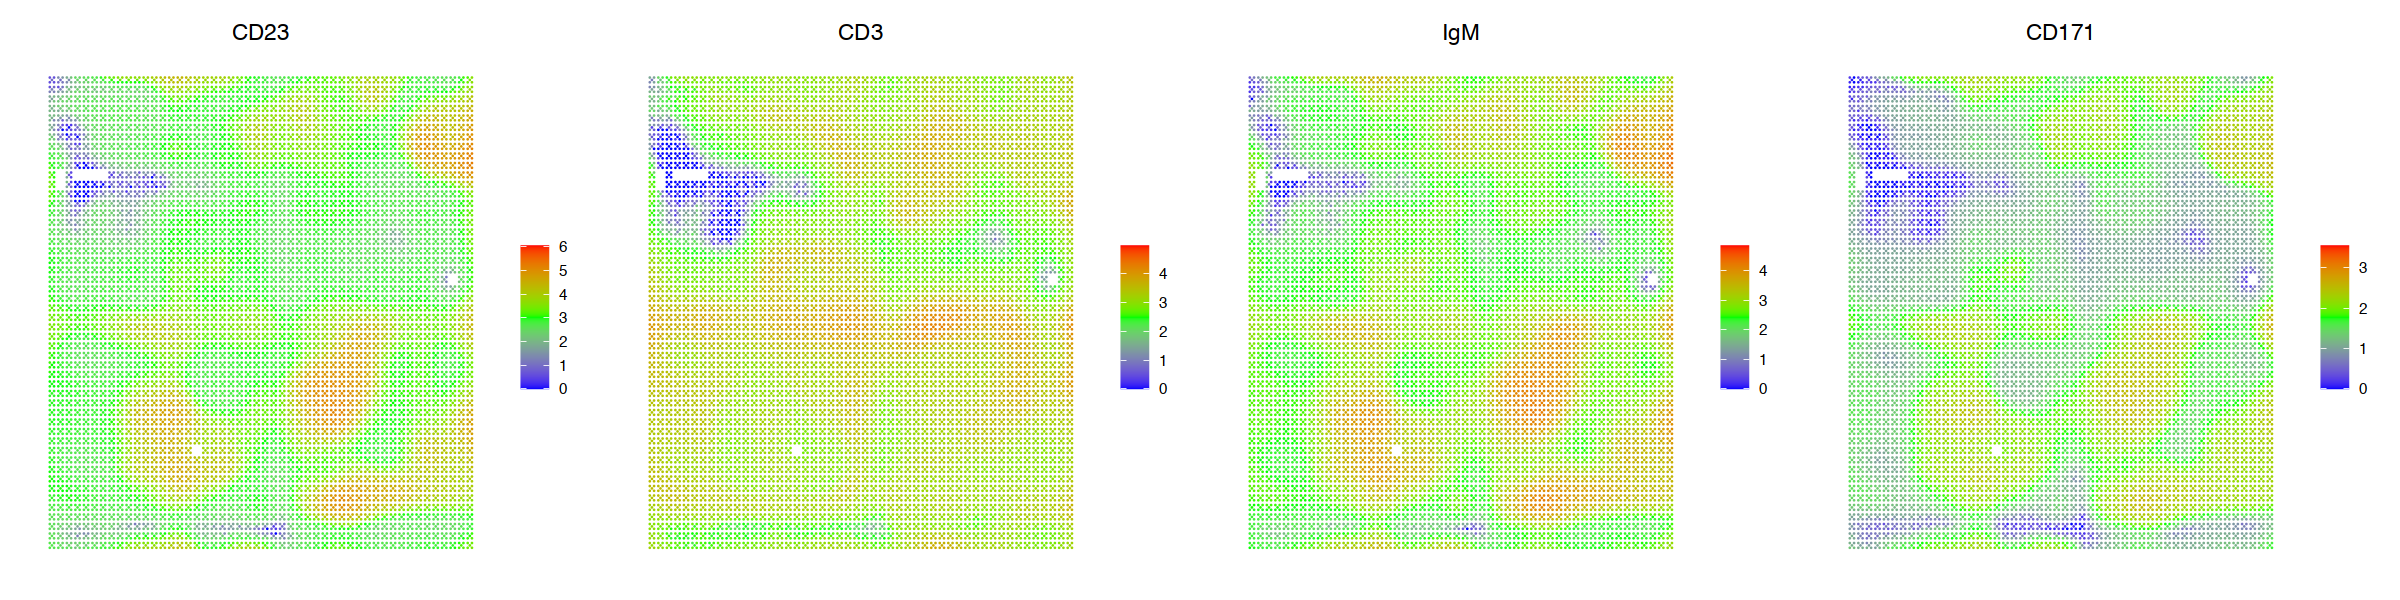

In [4]:
enhanced.pos <- read.table("enhanced_loc.txt", sep=",")
enhanced.protein <- read.table("protein_enhanced_denoised_counts.txt", sep=",")
colnames(enhanced.protein) <- protein.name
logenhanced.protein <- log(enhanced.protein+1)
enhanced.dat <- data.frame(exp=c(logenhanced.protein[, "CD23.TCTGTATAACCGTCT"], logenhanced.protein[, "CD3.CTCATTGTAACTCCT"],
                                 logenhanced.protein[, "IgM.TAGCGAGCCCGTATA"], logenhanced.protein[, "CD171..LICAM..GATGGACGACAATTC"]),
                           gene=rep(c("CD23", "CD3", "IgM", "CD171"), each=nrow(enhanced.pos)),
                           x=rep(enhanced.pos[,1], 4), y=rep(enhanced.pos[,2], 4))

p1_2 <- ggplot(enhanced.dat[enhanced.dat$gene=="CD23",], aes(x=x, y=y, color=exp)) + geom_point(size=0.15, shape=16) +
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="CD23","exp"]))) +
  scale_y_reverse() + ggtitle("CD23") + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), plot.title = element_text(hjust = 0.5))
p2_2 <- ggplot(enhanced.dat[enhanced.dat$gene=="CD3",], aes(x=x, y=y, color=exp)) + geom_point(size=0.15, shape=16) +
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="CD3","exp"]))) +
  scale_y_reverse() + ggtitle("CD3") + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), plot.title = element_text(hjust = 0.5))
p3_2 <- ggplot(enhanced.dat[enhanced.dat$gene=="IgM",], aes(x=x, y=y, color=exp)) + geom_point(size=0.15, shape=16) +
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="IgM","exp"]))) +
  scale_y_reverse() + ggtitle("IgM") + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), plot.title = element_text(hjust = 0.5))
p4_2 <- ggplot(enhanced.dat[enhanced.dat$gene=="CD171",], aes(x=x, y=y, color=exp)) + geom_point(size=0.15, shape=16) +
  scale_colour_gradientn(colours=rainbow(3, rev=T), limits=c(0, max(protein.data[protein.data$gene=="CD171","exp"]))) +
  scale_y_reverse() + ggtitle("CD171") + theme_classic() + 
  theme(axis.title=element_blank(), axis.ticks=element_blank(), axis.line=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), plot.title = element_text(hjust = 0.5))

options(repr.plot.width=20, repr.plot.height=5)
plot_grid(p1_2, p2_2, p3_2, p4_2, scale=0.95, nrow=1)